<a href="https://colab.research.google.com/github/sayarghoshroy/relevance-paradox/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import os
import sys
from tqdm import tqdm

In [2]:
filename = 'drive/My Drive/summworth/cleaned_document.json'

with open(filename, 'r+') as f:
  sent_scores = json.load(f)

In [3]:
# Grounding Spacy's Transformer Models
# !pip install -U spacy
import spacy
import nltk

# Restart Runtime for this to take effect
# !pip install spacy-transformers
# !python -m spacy download en
# !python -m spacy download en_trf_bertbaseuncased_lg
# !pip install -Iv botocore==1.17

In [4]:
# Required Downloads for NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

valid_POS = ['CD', 'FW', 'JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'UNK']
be_verbs = ['be', 'is', 'was', 'were']

def get_content_ratio(sentence):
    tokenized_set = nltk.word_tokenize(sentence)
    tagged_map = nltk.pos_tag(tokenized_set)

    count_content = 0
    count_total = len(tokenized_set)

    for elem in tagged_map:
      checker = elem[1]
      if checker in valid_POS and checker != 'POS' and elem[0] not in be_verbs:
          count_content += 1
          
    ratio = count_content / count_total
    return ratio

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
# Loading Spacy's BERT Model

# nlp = spacy.load('en_trf_bertbaseuncased_lg')

In [6]:
def clean(txt):
  txt = txt.replace("\n", " ").replace("\r", " ")
  punc_list = '!"#$&*+,-./;?@\^_~)('
  t = str.maketrans(dict.fromkeys(punc_list, " "))
  txt = txt.translate(t)
  t = str.maketrans(dict.fromkeys("'`", ""))
  txt = txt.translate(t)

  return txt

def regtok(txt):
  txt = clean(txt)
  regex = re.compile(r'(\d+|\s+|=|}}|\|)')
  tokens = [token for token in regex.split(txt)]
  return tokens

In [7]:
limit = len([key for key in sent_scores.keys()])
print("Number of Documents: " + str(limit))

Number of Documents: 82540


In [8]:
lengths = []
scores = []
similarity_scores = []
content_ratios = []

# Run test for a Specific Number of Documents
limit = 1000
doc_index = 0

for key in tqdm(sent_scores.keys(), total = limit):
    if doc_index >= limit:
        break
    doc_index += 1
    doc = sent_scores[key]['sent_labels']
    # print(doc)
    sent_embs = []
    full_sequence = ""
    
    for unit in doc:
      if len(unit) != 3:
          # Missing Parameters
          continue
      try:
          if unit[2] == 1:
              # checking if it is a grammatical sentence
              temp_score = float(unit[1])
              temp_length = int(len(regtok(unit[0])))
              # semantic_vec = nlp(unit[0])

              if temp_score > -1 and temp_score < 2000 and temp_length < 100:
                  # print(unit[0])
                  scores.append(temp_score)
                  lengths.append(temp_length)
                  content_ratios.append(get_content_ratio(unit[0].strip()))
                  # sent_embs.append(semantic_vec)
                  full_sequence = full_sequence + unit[0].strip() + " "

      except Exception as e:
         continue

    # doc_emb = nlp(full_sequence)
    # for emb in sent_embs:
    #     similarity_scores.append(doc_emb.similarity(emb))

100%|█████████▉| 996/1000 [00:32<00:00, 48.25it/s]

In [9]:
assert len(lengths) == len(scores)
assert len(content_ratios) == len(scores)
# assert len(lengths) == len(similarity_scores)
print("Number of Data Points: " + str(len(lengths)))

Number of Data Points: 30502


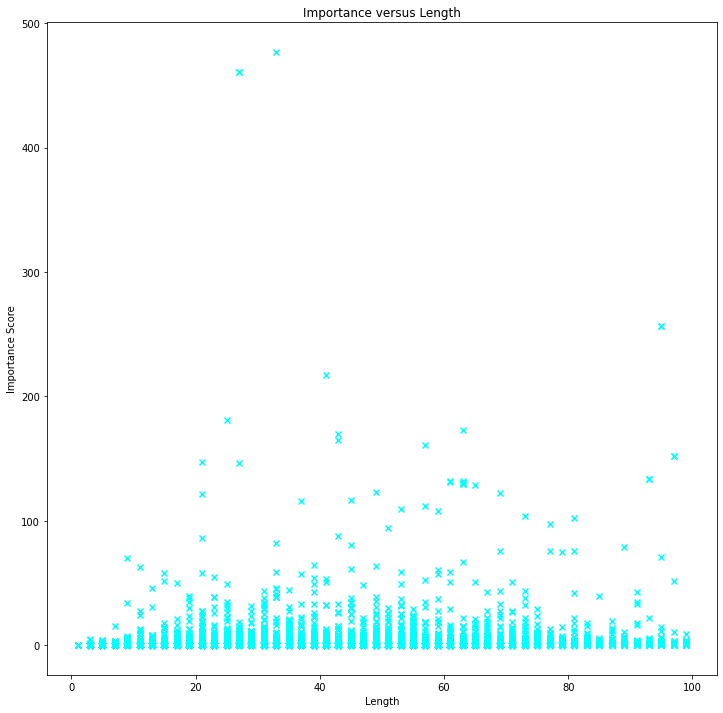

In [10]:
# Study: Importance versus Length
fig = plt.figure(figsize = (12, 12))
p = fig.add_subplot('111')
p.set_title('Importance versus Length')
p.set_xlabel('Length')
p.set_ylabel('Importance Score')
p.scatter(lengths, scores, color = 'cyan', marker = 'x')
plt.show()

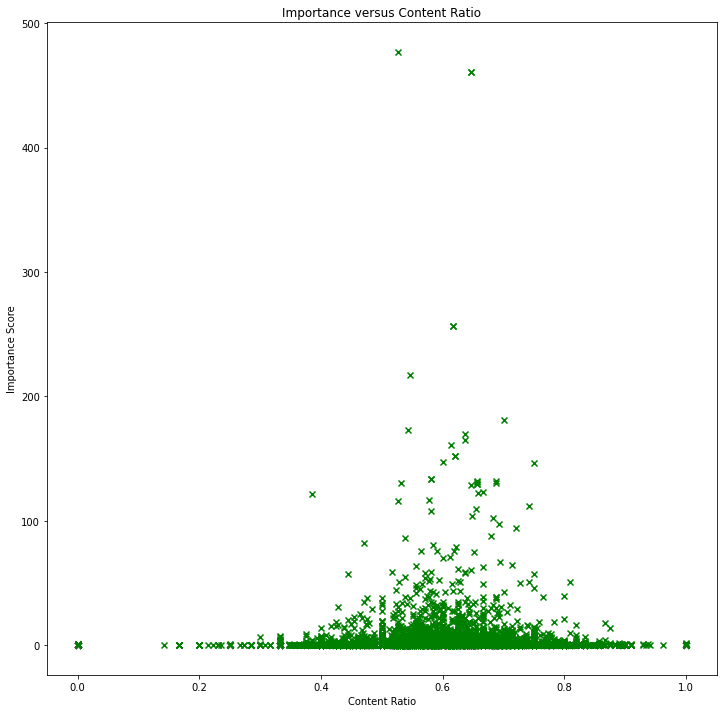

In [11]:
# Study: Importance versus Content Ratios
fig = plt.figure(figsize = (12, 12))
p = fig.add_subplot('111')
p.set_title('Importance versus Content Ratio')
p.set_xlabel('Content Ratio')
p.set_ylabel('Importance Score')
p.scatter(content_ratios, scores, color = 'green', marker = 'x')
plt.show()

In [12]:
# ^_^ Thank You